# 2. Estrategia de Análisis

## Enfoque Metodológico para Reducir Cancelaciones y Mejorar Ocupación

La estrategia combina estadísticos descriptivos y visualizaciones multivariadas para identificar patrones de cancelación y ocupación. Se analizan variables clave como lead time, ADR, tipo de depósito y tipo de hotel, usando histogramas, boxplots y comparaciones entre segmentos. El objetivo es traducir estos hallazgos en acciones concretas, como ajustar políticas de depósito según la anticipación de la reserva o diferenciar estrategias entre hoteles urbanos y de resort.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

# Importar utilidades
import sys
sys.path.append('../')
from src.utils_io import load_hotel_data, create_derived_features

# Cargar datos
df = load_hotel_data('../data/hotel_bookings_modified.csv')
df = create_derived_features(df)
print(f"Dataset cargado: {df.shape[0]:,} reservas con variables derivadas creadas")

Dataset cargado: 58,895 reservas con variables derivadas creadas


## 2.1 Definición del Problema de Negocio

In [27]:
print("PROBLEMA DE NEGOCIO")
print("=" * 80)

# Cuantificar el problema
total_bookings = len(df)
cancellations = df['is_canceled'].sum()
cancellation_rate = df['is_canceled'].mean()

# Impacto económico estimado
avg_adr = df[df['adr'] > 0]['adr'].mean()
avg_nights = (df['stays_in_weekend_nights'] + df['stays_in_week_nights']).mean()
potential_revenue_loss = cancellations * avg_adr * avg_nights

print(f"""
1. MAGNITUD DEL PROBLEMA:
   - Total de reservas: {total_bookings:,}
   - Cancelaciones: {cancellations:,}
   - Tasa de cancelación: {cancellation_rate*100:.2f}%
   - Pérdida potencial de ingresos: ${potential_revenue_loss:,.0f}

2. OBJETIVOS DE NEGOCIO:
   - Reducir tasa de cancelación en al menos 5 puntos porcentuales
   - Mejorar la ocupación efectiva en 10%
   - Optimizar políticas de revenue management
   - Segmentar clientes para estrategias diferenciadas

3. RESTRICCIONES:
   - Mantener satisfacción del cliente
   - Cumplir con regulaciones de cancelación
   - Considerar capacidad operativa limitada
   - Preservar reputación de marca
""")

PROBLEMA DE NEGOCIO

1. MAGNITUD DEL PROBLEMA:
   - Total de reservas: 58,895
   - Cancelaciones: 24,229
   - Tasa de cancelación: 41.14%
   - Pérdida potencial de ingresos: $9,258,507

2. OBJETIVOS DE NEGOCIO:
   - Reducir tasa de cancelación en al menos 5 puntos porcentuales
   - Mejorar la ocupación efectiva en 10%
   - Optimizar políticas de revenue management
   - Segmentar clientes para estrategias diferenciadas

3. RESTRICCIONES:
   - Mantener satisfacción del cliente
   - Cumplir con regulaciones de cancelación
   - Considerar capacidad operativa limitada
   - Preservar reputación de marca



## 2.2 Estrategia Analítica Propuesta

In [29]:
print("ESTRATEGIA DE ANÁLISIS")
print("=" * 80)

estrategia_texto = """
La estrategia combina tres pasos: (1) un análisis descriptivo segmentado por tipo de hotel,
temporada y cliente para detectar patrones de cancelación; (2) pruebas estadísticas simples
para validar que las diferencias encontradas sean reales y no ruido; y (3) un modelo de 
regresión logística interpretable que permita estimar la probabilidad de cancelación según
factores como lead_time, ADR y políticas de depósito. Este enfoque equilibra claridad para
los equipos de negocio con solidez estadística en la toma de decisiones.
"""

print(estrategia_texto)


# Guardar estrategia
with open('../reports/02_estrategia_analisis.txt', 'w') as f:
    f.write("ESTRATEGIA DE ANÁLISIS - TALLER 1\n")
    f.write("=" * 60 + "\n")
    f.write(estrategia_texto)

ESTRATEGIA DE ANÁLISIS

La estrategia combina tres pasos: (1) un análisis descriptivo segmentado por tipo de hotel,
temporada y cliente para detectar patrones de cancelación; (2) pruebas estadísticas simples
para validar que las diferencias encontradas sean reales y no ruido; y (3) un modelo de 
regresión logística interpretable que permita estimar la probabilidad de cancelación según
factores como lead_time, ADR y políticas de depósito. Este enfoque equilibra claridad para
los equipos de negocio con solidez estadística en la toma de decisiones.



## 2.3 Framework de Análisis Detallado

In [21]:
# Definir framework de análisis estructurado
framework = {
    'Fase 1: Preparación': [
        'Limpieza de datos (outliers, valores faltantes)',
        'Ingeniería de variables (total_guests, lead_time_bucket, season)',
        'Validación de calidad de datos'
    ],
    'Fase 2: Análisis Exploratorio': [
        'Distribuciones univariadas de variables clave',
        'Análisis bivariado (cancelación vs predictores)',
        'Matriz de correlación y detección de multicolinealidad',
        'Segmentación inicial por dimensiones de negocio'
    ],
    'Fase 3: Análisis Estadístico': [
        'Tablas de contingencia y tasas por segmento',
        'Tests de hipótesis (chi-cuadrado, Mann-Whitney)',
        'Cálculo de tamaños de efecto',
        'Intervalos de confianza para métricas clave'
    ],
    'Fase 4: Modelado': [
        'Selección de variables por importancia',
        'Entrenamiento de modelo logístico',
        'Validación y métricas de desempeño',
        'Interpretación de coeficientes y odds ratios'
    ],
    'Fase 5: Insights y Recomendaciones': [
        'Identificación de factores críticos',
        'Cuantificación de oportunidades',
        'Diseño de estrategias segmentadas',
        'Priorización por impacto y factibilidad'
    ]
}

print("FRAMEWORK DE ANÁLISIS ESTRUCTURADO")
print("=" * 80)
for fase, tareas in framework.items():
    print(f"\n{fase}:")
    for i, tarea in enumerate(tareas, 1):
        print(f"  {i}. {tarea}")

FRAMEWORK DE ANÁLISIS ESTRUCTURADO

Fase 1: Preparación:
  1. Limpieza de datos (outliers, valores faltantes)
  2. Ingeniería de variables (total_guests, lead_time_bucket, season)
  3. Validación de calidad de datos

Fase 2: Análisis Exploratorio:
  1. Distribuciones univariadas de variables clave
  2. Análisis bivariado (cancelación vs predictores)
  3. Matriz de correlación y detección de multicolinealidad
  4. Segmentación inicial por dimensiones de negocio

Fase 3: Análisis Estadístico:
  1. Tablas de contingencia y tasas por segmento
  2. Tests de hipótesis (chi-cuadrado, Mann-Whitney)
  3. Cálculo de tamaños de efecto
  4. Intervalos de confianza para métricas clave

Fase 4: Modelado:
  1. Selección de variables por importancia
  2. Entrenamiento de modelo logístico
  3. Validación y métricas de desempeño
  4. Interpretación de coeficientes y odds ratios

Fase 5: Insights y Recomendaciones:
  1. Identificación de factores críticos
  2. Cuantificación de oportunidades
  3. Diseño 

## 2.4 Variables y Segmentos Prioritarios

In [22]:
# Identificar variables prioritarias para el análisis
variables_analysis = {
    'Target': ['is_canceled'],
    'Temporales': ['lead_time', 'arrival_date_month', 'arrival_date_week_number'],
    'Cliente': ['customer_type', 'is_repeated_guest', 'previous_cancellations', 'total_guests', 'is_family'],
    'Producto': ['hotel', 'reserved_room_type', 'assigned_room_type', 'meal'],
    'Comerciales': ['market_segment', 'distribution_channel', 'deposit_type', 'booking_changes'],
    'Económicas': ['adr', 'days_in_waiting_list', 'total_of_special_requests'],
    'Derivadas': ['total_stay_nights', 'lead_time_bucket', 'season', 'room_type_diff']
}

print("VARIABLES PRIORITARIAS POR CATEGORÍA")
print("=" * 80)
for categoria, variables in variables_analysis.items():
    print(f"\n{categoria}:")
    print(f"  {', '.join(variables)}")

# Definir segmentos de análisis
segmentos = [
    ('Tipo de Hotel', 'hotel'),
    ('Temporada', 'season'),
    ('Canal de Distribución', 'distribution_channel'),
    ('Tipo de Cliente', 'customer_type'),
    ('Ventana de Reserva', 'lead_time_bucket'),
    ('Tipo de Depósito', 'deposit_type')
]

print("\n\nSEGMENTOS DE ANÁLISIS PRIORITARIOS")
print("=" * 80)
for nombre, variable in segmentos:
    unique_values = df[variable].nunique() if variable in df.columns else 'Variable derivada'
    print(f"  • {nombre:25} ({variable}): {unique_values} categorías")

VARIABLES PRIORITARIAS POR CATEGORÍA

Target:
  is_canceled

Temporales:
  lead_time, arrival_date_month, arrival_date_week_number

Cliente:
  customer_type, is_repeated_guest, previous_cancellations, total_guests, is_family

Producto:
  hotel, reserved_room_type, assigned_room_type, meal

Comerciales:
  market_segment, distribution_channel, deposit_type, booking_changes

Económicas:
  adr, days_in_waiting_list, total_of_special_requests

Derivadas:
  total_stay_nights, lead_time_bucket, season, room_type_diff


SEGMENTOS DE ANÁLISIS PRIORITARIOS
  • Tipo de Hotel             (hotel): 2 categorías
  • Temporada                 (season): 4 categorías
  • Canal de Distribución     (distribution_channel): 5 categorías
  • Tipo de Cliente           (customer_type): 4 categorías
  • Ventana de Reserva        (lead_time_bucket): 8 categorías
  • Tipo de Depósito          (deposit_type): 4 categorías


## 2.5 Métricas de Éxito y KPIs

MÉTRICAS DE ÉXITO Y KPIs
                     KPI       Actual                   Meta Impacto Medición
     Tasa de Cancelación       41.14%                   <30%    Alto  Mensual
      Lead Time Promedio     100 días Optimizar por segmento   Medio  Semanal
ADR (Average Daily Rate)       $97.84           +10% año/año    Alto   Diaria
      Ocupación Efectiva        58.9%                   >75%    Alto   Diaria
  Revenue por Habitación Por calcular           +15% año/año    Alto  Mensual
 Conversión con Depósito        11.1%                   >30%   Medio  Semanal


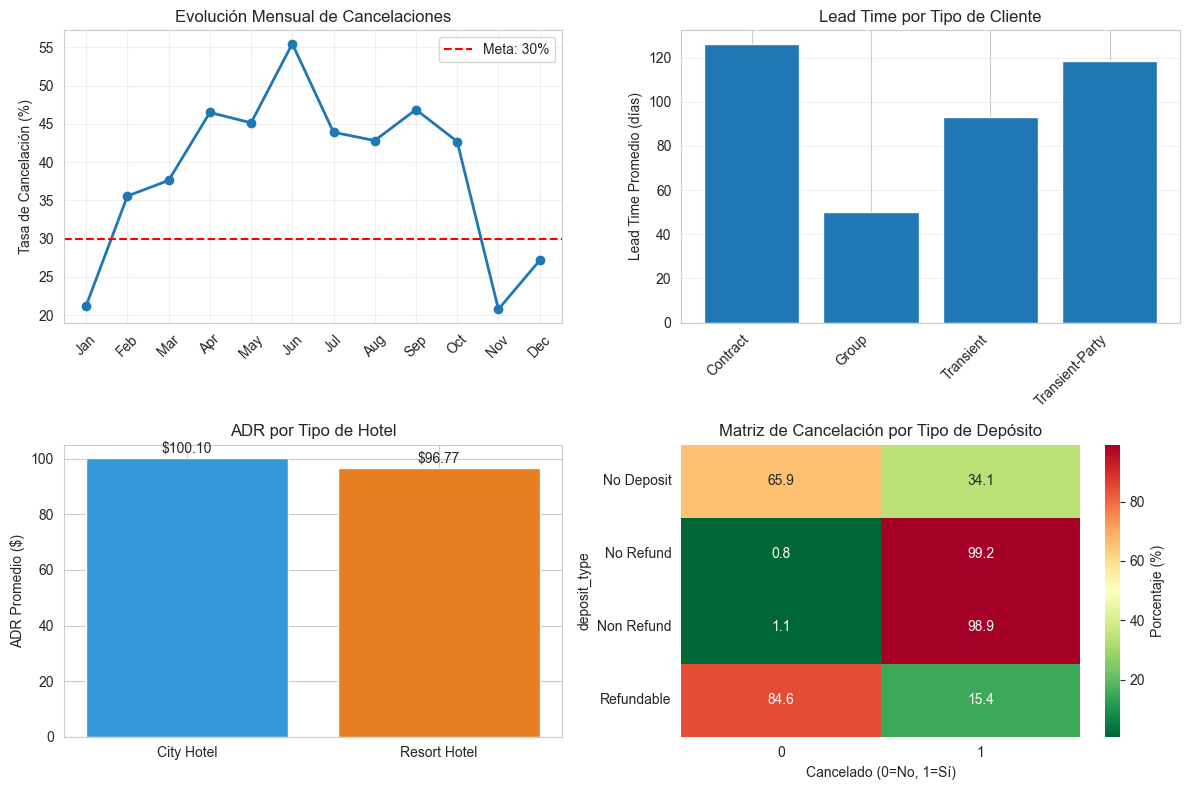

In [23]:
# Definir KPIs y métricas de éxito
print("MÉTRICAS DE ÉXITO Y KPIs")
print("=" * 80)

kpis = pd.DataFrame([
    {'KPI': 'Tasa de Cancelación', 
     'Actual': f"{df['is_canceled'].mean()*100:.2f}%",
     'Meta': '<30%',
     'Impacto': 'Alto',
     'Medición': 'Mensual'},
    
    {'KPI': 'Lead Time Promedio', 
     'Actual': f"{df['lead_time'].mean():.0f} días",
     'Meta': 'Optimizar por segmento',
     'Impacto': 'Medio',
     'Medición': 'Semanal'},
    
    {'KPI': 'ADR (Average Daily Rate)', 
     'Actual': f"${df[df['adr']>0]['adr'].mean():.2f}",
     'Meta': '+10% año/año',
     'Impacto': 'Alto',
     'Medición': 'Diaria'},
    
    {'KPI': 'Ocupación Efectiva', 
     'Actual': f"{(1-df['is_canceled'].mean())*100:.1f}%",
     'Meta': '>75%',
     'Impacto': 'Alto',
     'Medición': 'Diaria'},
    
    {'KPI': 'Revenue por Habitación', 
     'Actual': 'Por calcular',
     'Meta': '+15% año/año',
     'Impacto': 'Alto',
     'Medición': 'Mensual'},
    
    {'KPI': 'Conversión con Depósito', 
     'Actual': f"{(df['deposit_type']!='No Deposit').mean()*100:.1f}%",
     'Meta': '>30%',
     'Impacto': 'Medio',
     'Medición': 'Semanal'}
])

print(kpis.to_string(index=False))

# Visualización de métricas actuales vs objetivo
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Tasa de cancelación por mes
monthly_cancel = df.groupby('arrival_date_month')['is_canceled'].mean() * 100
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_cancel = monthly_cancel.reindex(month_order)
axes[0, 0].plot(range(12), monthly_cancel.values, marker='o', linewidth=2)
axes[0, 0].axhline(y=30, color='red', linestyle='--', label='Meta: 30%')
axes[0, 0].set_xticks(range(12))
axes[0, 0].set_xticklabels([m[:3] for m in month_order], rotation=45)
axes[0, 0].set_ylabel('Tasa de Cancelación (%)')
axes[0, 0].set_title('Evolución Mensual de Cancelaciones')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Lead time por tipo de cliente
lead_by_customer = df.groupby('customer_type')['lead_time'].mean()
axes[0, 1].bar(range(len(lead_by_customer)), lead_by_customer.values)
axes[0, 1].set_xticks(range(len(lead_by_customer)))
axes[0, 1].set_xticklabels(lead_by_customer.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Lead Time Promedio (días)')
axes[0, 1].set_title('Lead Time por Tipo de Cliente')
axes[0, 1].grid(axis='y', alpha=0.3)

# ADR por tipo de hotel
adr_by_hotel = df[df['adr']>0].groupby('hotel')['adr'].mean()
axes[1, 0].bar(range(len(adr_by_hotel)), adr_by_hotel.values, color=['#3498db', '#e67e22'])
axes[1, 0].set_xticks(range(len(adr_by_hotel)))
axes[1, 0].set_xticklabels(adr_by_hotel.index)
axes[1, 0].set_ylabel('ADR Promedio ($)')
axes[1, 0].set_title('ADR por Tipo de Hotel')
for i, v in enumerate(adr_by_hotel.values):
    axes[1, 0].text(i, v + 2, f'${v:.2f}', ha='center')

# Matriz de conversión
conversion_matrix = pd.crosstab(df['deposit_type'], df['is_canceled'], normalize='index') * 100
sns.heatmap(conversion_matrix, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=axes[1, 1],
           cbar_kws={'label': 'Porcentaje (%)'})
axes[1, 1].set_title('Matriz de Cancelación por Tipo de Depósito')
axes[1, 1].set_xlabel('Cancelado (0=No, 1=Sí)')

plt.tight_layout()
plt.savefig('../reports/figures/02_kpis_overview.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.6 Plan de Implementación

PLAN DE IMPLEMENTACIÓN DE LA ESTRATEGIA

FASE 1: QUICK WINS (Semanas 1-2)
• Identificar segmentos de alto riesgo mediante análisis descriptivo
• Implementar alertas tempranas para reservas con alta probabilidad de cancelación
• Ajustar políticas de depósito para lead_time > 60 días

FASE 2: OPTIMIZACIÓN (Semanas 3-4)
• Desarrollar modelo predictivo de cancelaciones
• Diseñar estrategias de pricing dinámico por segmento
• Implementar overbooking controlado basado en probabilidades

FASE 3: ESCALAMIENTO (Mes 2)
• Automatizar scoring de reservas en tiempo real
• Integrar recomendaciones en sistemas de reservas
• Establecer dashboard de monitoreo continuo

FASE 4: MEJORA CONTINUA (Ongoing)
• Reentrenar modelos con datos actualizados
• A/B testing de políticas propuestas
• Refinamiento basado en feedback operativo


MATRIZ DE PRIORIZACIÓN DE ACCIONES
                            Acción  Impacto  Esfuerzo Prioridad
Política de depósitos diferenciada        9         3      Alta
Modelo predict

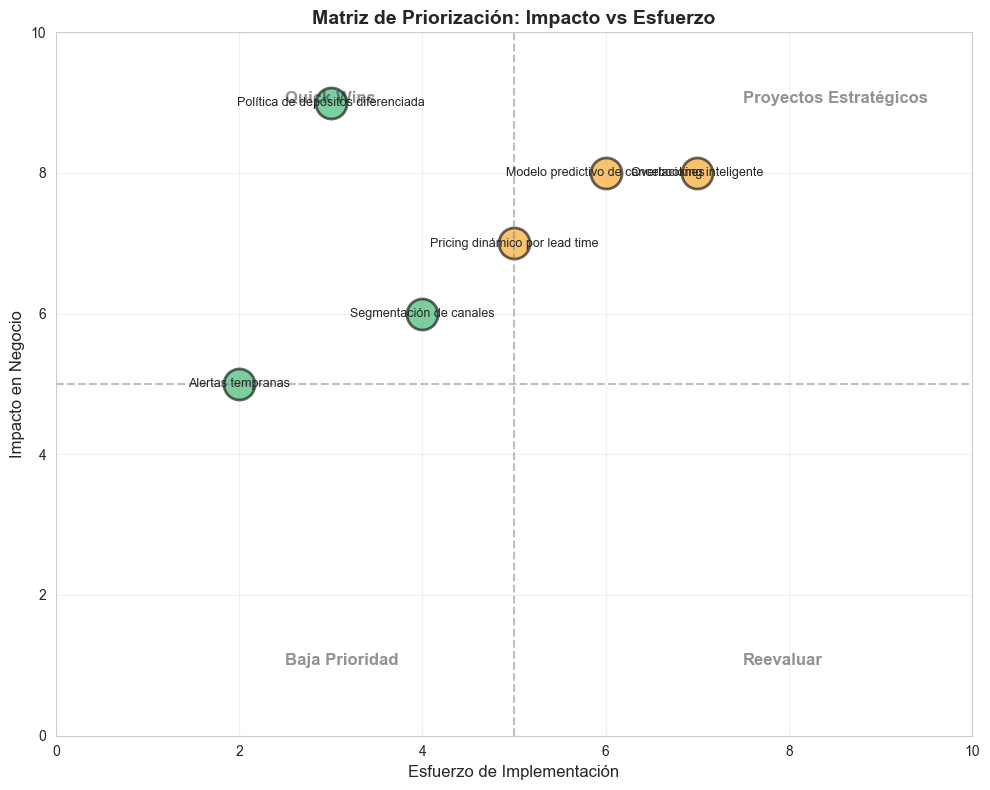

In [24]:
print("PLAN DE IMPLEMENTACIÓN DE LA ESTRATEGIA")
print("=" * 80)

plan_implementacion = """
FASE 1: QUICK WINS (Semanas 1-2)
• Identificar segmentos de alto riesgo mediante análisis descriptivo
• Implementar alertas tempranas para reservas con alta probabilidad de cancelación
• Ajustar políticas de depósito para lead_time > 60 días

FASE 2: OPTIMIZACIÓN (Semanas 3-4)
• Desarrollar modelo predictivo de cancelaciones
• Diseñar estrategias de pricing dinámico por segmento
• Implementar overbooking controlado basado en probabilidades

FASE 3: ESCALAMIENTO (Mes 2)
• Automatizar scoring de reservas en tiempo real
• Integrar recomendaciones en sistemas de reservas
• Establecer dashboard de monitoreo continuo

FASE 4: MEJORA CONTINUA (Ongoing)
• Reentrenar modelos con datos actualizados
• A/B testing de políticas propuestas
• Refinamiento basado en feedback operativo
"""

print(plan_implementacion)

# Matriz de priorización
prioridades = pd.DataFrame([
    {'Acción': 'Política de depósitos diferenciada', 'Impacto': 9, 'Esfuerzo': 3, 'Prioridad': 'Alta'},
    {'Acción': 'Modelo predictivo de cancelaciones', 'Impacto': 8, 'Esfuerzo': 6, 'Prioridad': 'Media'},
    {'Acción': 'Pricing dinámico por lead time', 'Impacto': 7, 'Esfuerzo': 5, 'Prioridad': 'Media'},
    {'Acción': 'Overbooking inteligente', 'Impacto': 8, 'Esfuerzo': 7, 'Prioridad': 'Media'},
    {'Acción': 'Segmentación de canales', 'Impacto': 6, 'Esfuerzo': 4, 'Prioridad': 'Alta'},
    {'Acción': 'Alertas tempranas', 'Impacto': 5, 'Esfuerzo': 2, 'Prioridad': 'Alta'}
])

print("\nMATRIZ DE PRIORIZACIÓN DE ACCIONES")
print("=" * 80)
print(prioridades.to_string(index=False))

# Visualización de matriz de priorización
fig, ax = plt.subplots(figsize=(10, 8))
colors = {'Alta': '#27ae60', 'Media': '#f39c12', 'Baja': '#e74c3c'}
for _, row in prioridades.iterrows():
    ax.scatter(row['Esfuerzo'], row['Impacto'], s=500, alpha=0.6, 
              c=colors[row['Prioridad']], edgecolors='black', linewidths=2)
    ax.annotate(row['Acción'], (row['Esfuerzo'], row['Impacto']), 
               ha='center', va='center', fontsize=9, wrap=True)

ax.set_xlabel('Esfuerzo de Implementación', fontsize=12)
ax.set_ylabel('Impacto en Negocio', fontsize=12)
ax.set_title('Matriz de Priorización: Impacto vs Esfuerzo', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

# Añadir cuadrantes
ax.axhline(y=5, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=5, color='gray', linestyle='--', alpha=0.5)
ax.text(2.5, 9, 'Quick Wins', fontsize=12, fontweight='bold', alpha=0.5)
ax.text(7.5, 9, 'Proyectos Estratégicos', fontsize=12, fontweight='bold', alpha=0.5)
ax.text(2.5, 1, 'Baja Prioridad', fontsize=12, fontweight='bold', alpha=0.5)
ax.text(7.5, 1, 'Reevaluar', fontsize=12, fontweight='bold', alpha=0.5)

plt.tight_layout()
plt.savefig('../reports/figures/02_priority_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.7 Resumen Ejecutivo de la Estrategia

In [30]:
print("RESUMEN EJECUTIVO - ESTRATEGIA DE ANÁLISIS")
print("=" * 80)

resumen = f"""
CONTEXTO:
El dataset muestra una tasa de cancelación del {df['is_canceled'].mean()*100:.1f}%, 
lo que implica un impacto significativo en ingresos y en la planeación de ocupación.

ESTRATEGIA PROPUESTA:
Se trabajará en tres frentes: análisis descriptivo segmentado (hotel, canal, temporada, cliente),
validación estadística de las diferencias encontradas y un modelo predictivo sencillo (regresión logística)
para estimar la probabilidad de cancelación según variables clave como lead_time, ADR y depósito.

TÉCNICAS A UTILIZAR:
• Estadísticos básicos y visualizaciones multivariadas para detectar patrones
• Pruebas estadísticas no paramétricas para confirmar hallazgos
• Regresión logística interpretable para cuantificar factores de riesgo

OBJETIVO:
Traducir los hallazgos en acciones prácticas, como ajustar políticas de depósito según
la anticipación de la reserva y diferenciar estrategias entre hoteles urbanos y de resort.
"""

print(resumen)

# Guardar resumen
with open('../reports/02_estrategia_resumen.txt', 'w') as f:
    f.write("ESTRATEGIA DE ANÁLISIS - RESUMEN EJECUTIVO\n")
    f.write("=" * 60 + "\n")
    f.write(resumen)

print("\n✓ Estrategia de análisis completada")
print("✓ Visualizaciones guardadas en reports/figures/")
print("✓ Documentación guardada en reports/")


RESUMEN EJECUTIVO - ESTRATEGIA DE ANÁLISIS

CONTEXTO:
El dataset muestra una tasa de cancelación del 41.1%, 
lo que implica un impacto significativo en ingresos y en la planeación de ocupación.

ESTRATEGIA PROPUESTA:
Se trabajará en tres frentes: análisis descriptivo segmentado (hotel, canal, temporada, cliente),
validación estadística de las diferencias encontradas y un modelo predictivo sencillo (regresión logística)
para estimar la probabilidad de cancelación según variables clave como lead_time, ADR y depósito.

TÉCNICAS A UTILIZAR:
• Estadísticos básicos y visualizaciones multivariadas para detectar patrones
• Pruebas estadísticas no paramétricas para confirmar hallazgos
• Regresión logística interpretable para cuantificar factores de riesgo

OBJETIVO:
Traducir los hallazgos en acciones prácticas, como ajustar políticas de depósito según
la anticipación de la reserva y diferenciar estrategias entre hoteles urbanos y de resort.


✓ Estrategia de análisis completada
✓ Visualizacione